출처 : pytorch 튜트리얼

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5, ))
])

training_set = torchvision.datasets.FashionMNIST('./data', train = True, transform = transform, download = True)
validation_set = torchvision.datasets.FashionMNIST('./data', train = False, transform = transform, download = True)

training_loader = torch.utils.data.DataLoader(training_set, batch_size = 4, shuffle = True, num_workers = 2)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=4, shuffle=False, num_workers=2)


classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Training set has 60000 instances
Validation set has 10000 instances


Shirt  T-shirt/top  Coat  Trouser


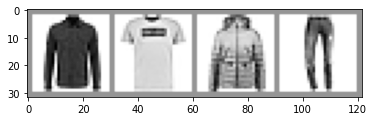

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def matplotlib_imshow(img, one_channel = False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

dataiter = iter(training_loader)
images, labels = dataiter.next()

img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
print('  '.join(classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class GarmentClassificer(nn.Module):
    def __init__(self):
        super(GarmentClassificer, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4* 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = GarmentClassificer()

loss function

In [5]:
loss_fn = torch.nn.CrossEntropyLoss()

dummy_outputs = torch.rand(4, 10)
dummy_labels = torch.tensor([1, 5, 3, 7])

print(dummy_outputs)
print(dummy_labels)

loss = loss_fn(dummy_outputs, dummy_labels)
print('Total loss for this batch: {}'.format(loss.item()))

tensor([[0.7605, 0.5137, 0.4469, 0.8153, 0.9985, 0.7839, 0.0197, 0.1994, 0.6618,
         0.4147],
        [0.3134, 0.9601, 0.9827, 0.0295, 0.4627, 0.5129, 0.7808, 0.3445, 0.2126,
         0.4404],
        [0.5797, 0.6143, 0.6264, 0.8896, 0.8091, 0.0385, 0.4309, 0.9873, 0.9790,
         0.9626],
        [0.3937, 0.0418, 0.6387, 0.3867, 0.8411, 0.6924, 0.2972, 0.6436, 0.4625,
         0.9795]])
tensor([1, 5, 3, 7])
Total loss for this batch: 2.2752528190612793


optimizer

In [6]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

In [7]:
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.

    for i, data in enumerate(training_loader):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = model(inputs)

        loss = loss_fn(outputs, labels)
        loss.backward()

        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * len(training_loader) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [8]:
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 5

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    model.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)


    model.train(False)

    running_vloss = 0.0
    for i, vdata in enumerate(validation_loader):
        vinputs, vlabels = vdata
        voutputs = model(vinputs)
        vloss = loss_fn(voutputs, vlabels)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))


    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        model_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1

EPOCH 1:
  batch 1000 loss: 1.5671167803108692
  batch 2000 loss: 0.8248351993635297
  batch 3000 loss: 0.711726559043862
  batch 4000 loss: 0.6517249317327515
  batch 5000 loss: 0.5898147893063724
  batch 6000 loss: 0.5693873461997137
  batch 7000 loss: 0.5518451908226125
  batch 8000 loss: 0.5099076818693429
  batch 9000 loss: 0.48341899379482495
  batch 10000 loss: 0.4866747454069555
  batch 11000 loss: 0.45973578450782226
  batch 12000 loss: 0.4348543183146976
  batch 13000 loss: 0.45335238987067716
  batch 14000 loss: 0.4423953817980364
  batch 15000 loss: 0.42644554069824514
LOSS train 0.42644554069824514 valid 0.4484938085079193
EPOCH 2:
  batch 1000 loss: 0.41369327812065604
  batch 2000 loss: 0.40473329938470853
  batch 3000 loss: 0.3831506966842571
  batch 4000 loss: 0.3922187709039717
  batch 5000 loss: 0.4004162443574751
  batch 6000 loss: 0.4023652327535674
  batch 7000 loss: 0.3455898296571104
  batch 8000 loss: 0.359971823838423
  batch 9000 loss: 0.35730219385653617
  b

In [ ]:
saved_model = GarmentClassificer()
saved_model.load_state_dict(torch.load(PATH))